In [73]:
import os
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go
import plotly.io as pio
import yfinance as yf

from datetime import date
from datetime import datetime

In [74]:
ticker = "BABA"
from_date = datetime(2020, 1, 1)
to_date = datetime.today()
interval = "1d"

In [75]:
ticker_csv = os.path.join(os.getcwd(), "data", "{}.csv".format(ticker))

df = yf.download(tickers = ticker,
                 start = from_date,
                 end = to_date,
                 interval = interval
                )

[*********************100%***********************]  1 of 1 completed


In [76]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,216.600006,219.979996,216.539993,219.770004,219.770004,15873500
2020-01-03,216.350006,218.203003,216.009995,217.000000,217.000000,8604500
2020-01-06,214.889999,217.160004,214.089996,216.639999,216.639999,11885500
2020-01-07,217.639999,218.940002,216.690002,217.630005,217.630005,9388000
2020-01-08,216.600006,220.649994,216.320007,218.000000,218.000000,11959100


Succintly:
 1. calculate the 10 days SMA of the ATR.
 2. calculate the highest high over the last 10 days.
 3. subtract $3 * ATR_{10}$ from the highest high of the last 10 days.
 4. calculate the highest high of the last 20 days of this preliminary value, this is your long stop.
 5. calculate the lowest low over the last 10 days.
 6. add $3 * ATR_{10}$ to the lowest low of the last 10 days.
 7. calculate the lowest low of the last 20 days of this preliminary value, this is your short stop.
 
You can use looser ATR multipliers or tighter ATR multipliers. The figure 7.4 in page 95 of the original book shows long stops with a value of 1.5 ATR and 3.5 ATR for a long trade of a Japanese Yen futures 09/93 contract, but i had no luck finding freely available historic data for this contract to compare.

In [77]:
cksp = ta.trend.cksp(df["High"], df["Low"], df["Close"], tvmode = False)
df["CKlong"] = cksp[cksp.columns[0]]
df["CKshort"] = cksp[cksp.columns[1]]

df.head()

,Open,High,Low,Close,Adj Close,Volume,CKlong,CKshort
Date,,,,,,,,
2020-01-02,216.600006,219.979996,216.539993,219.770004,219.770004,15873500,NaN,NaN
2020-01-03,216.350006,218.203003,216.009995,217.000000,217.000000,8604500,NaN,NaN
2020-01-06,214.889999,217.160004,214.089996,216.639999,216.639999,11885500,NaN,NaN
2020-01-07,217.639999,218.940002,216.690002,217.630005,217.630005,9388000,NaN,NaN
2020-01-08,216.600006,220.649994,216.320007,218.000000,218.000000,11959100,NaN,NaN


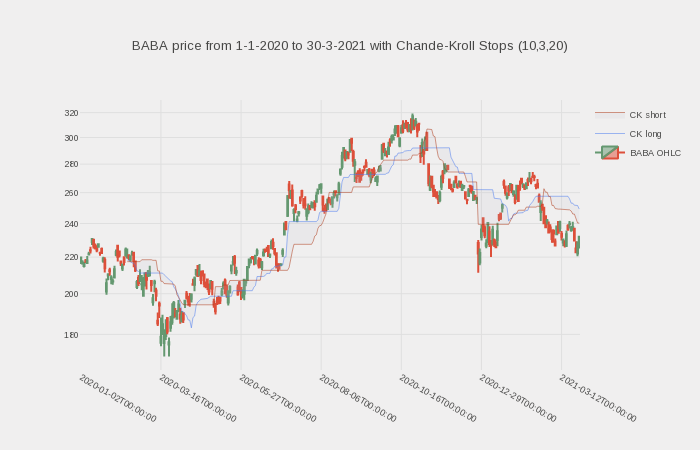

In [78]:
fig = go.Figure()

interp = "linear"

title = "{} price from {} to {} with Chande-Kroll Stops (10,3,20)".format(ticker,
    "{}-{}-{}".format(from_date.day, from_date.month, from_date.year),
    "{}-{}-{}".format(to_date.day, to_date.month, to_date.year))

hovertext = []
for i in range(len(df["Open"])):
    hovertext.append(
        "Open: {:.3f} <br>High: {:.3f}<br>Low: {:.3f}<br>Close: {:.3f}".format(
        df["Open"][i], df["High"][i], df["Low"][i], df["Close"][i]))
    
ckltext = []
for i in range(len(df["CKlong"])):
    ckltext.append("CK Long: {:.3f}".format(df["CKlong"][i]))
    
ckstext = []
for i in range(len(df["CKshort"])):
    ckstext.append("CK Short: {:.3f}".format(df["CKshort"][i]))
    

fig.add_trace(
    go.Candlestick(
        x = df.index,
        open = df["Open"], high = df["High"], low = df["Low"], close = df["Close"],
        name = "{} OHLC".format(ticker),
        text = hovertext,
        hoverinfo = "text",
    ),)

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df["CKlong"],
        name = "CK long",
        line = dict(shape = interp, color = "rgba(0, 120, 240, 0.5)", width = 1,),        
        text = ckltext,
        hoverinfo = "text",
    ),)

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df["CKshort"],
        fill = "tonexty",
        fillcolor = "rgba(180, 180, 200, 0.125)",            
        name = "CK short",
        line = dict(shape = interp, color = "rgba(200, 40, 10, 0.5)", width = 1,),        
        text = ckstext,
        hoverinfo = "text",
    ),)

# plot layout options
layout = dict(
    xaxis = go.layout.XAxis(
        type = "category",
        showticklabels = True,
        tick0 = 0.0,
        dtick = 50,
        rangeslider = dict(visible = False)
    ),
    yaxis = dict(
        type = "log",
        anchor = "x2",
        autorange = True,
        tickmode = "auto",
    ),
    # annotations = annotations,
    #width = 1000, height = 800,
    margin = dict(
        autoexpand = True,
        #r = 100, t = 65, b = 110, l = 100
    ),
    template = "gridon",
    plot_bgcolor = "rgb(240, 240, 240)",
    paper_bgcolor = "rgb(240, 240, 240)",
    dragmode = "zoom",
    hovermode = "closest",
)

fig.update_layout(layout)
fig.update_layout(
    title = title,
    font=dict(
        size=9,
    ),
)

fig.show()

The plot above has the Chande-Kroll stop *tvmode* set to **False**. This is the behaviour as specified in the book with ```p=10, x=3, q=20```.

The following plot sets the *tvmode* set to **True** (*its default behaviour*). This mode retains the compatibility with [Trading View](https://www.tradingview.com/support/solutions/43000589105-chande-kroll-stop/)

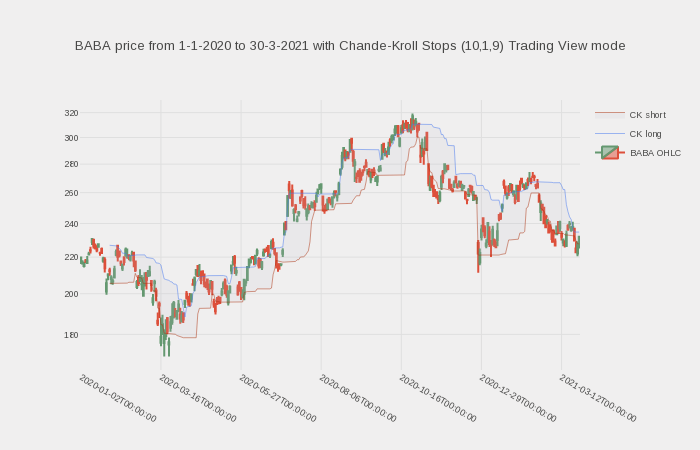

In [79]:
cksp = ta.trend.cksp(df["High"], df["Low"], df["Close"], tvmode = True)
df["CKlong"] = cksp[cksp.columns[0]]
df["CKshort"] = cksp[cksp.columns[1]]

fig = go.Figure()

interp = "linear"

title = "{} price from {} to {} with Chande-Kroll Stops (10,1,9) Trading View mode".format(ticker,
    "{}-{}-{}".format(from_date.day, from_date.month, from_date.year),
    "{}-{}-{}".format(to_date.day, to_date.month, to_date.year))

hovertext = []
for i in range(len(df["Open"])):
    hovertext.append(
        "Open: {:.3f} <br>High: {:.3f}<br>Low: {:.3f}<br>Close: {:.3f}".format(
        df["Open"][i], df["High"][i], df["Low"][i], df["Close"][i]))
    
ckltext = []
for i in range(len(df["CKlong"])):
    ckltext.append("CK Long: {:.3f}".format(df["CKlong"][i]))
    
ckstext = []
for i in range(len(df["CKshort"])):
    ckstext.append("CK Short: {:.3f}".format(df["CKshort"][i]))
    

fig.add_trace(
    go.Candlestick(
        x = df.index,
        open = df["Open"], high = df["High"], low = df["Low"], close = df["Close"],
        name = "{} OHLC".format(ticker),
        text = hovertext,
        hoverinfo = "text",
    ),)

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df["CKlong"],
        name = "CK long",
        line = dict(shape = interp, color = "rgba(0, 120, 240, 0.5)", width = 1,),        
        text = ckltext,
        hoverinfo = "text",
    ),)

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df["CKshort"],
        fill = "tonexty",
        fillcolor = "rgba(180, 180, 200, 0.125)",            
        name = "CK short",
        line = dict(shape = interp, color = "rgba(200, 40, 10, 0.5)", width = 1,),        
        text = ckstext,
        hoverinfo = "text",
    ),)

# plot layout options
layout = dict(
    xaxis = go.layout.XAxis(
        type = "category",
        showticklabels = True,
        tick0 = 0.0,
        dtick = 50,
        rangeslider = dict(visible = False)
    ),
    yaxis = dict(
        type = "log",
        anchor = "x2",
        autorange = True,
        tickmode = "auto",
    ),
    # annotations = annotations,
    #width = 1000, height = 800,
    margin = dict(
        autoexpand = True,
        #r = 100, t = 65, b = 110, l = 100
    ),
    template = "gridon",
    plot_bgcolor = "rgb(240, 240, 240)",
    paper_bgcolor = "rgb(240, 240, 240)",
    dragmode = "zoom",
    hovermode = "closest",
)

fig.update_layout(layout)
fig.update_layout(
    title = title,
    font=dict(
        size=9,
    ),
)

fig.show()